## Spectral data processing for the ANU forest spectrometer from raw instrument output to reflectance

### This Notebook outlines a workflow in Python to iterate through subfolders of Spectral data collected by the ANU Forest Spectrometer. Dark-corrected and reordered files are imported (.bin) and processed alongside metadata to NetCDF (.nc) files.


### Steps loosely follow:
### - Cell 1 → Imports & configuration paths
### - Cell 2 → The main panel_reflectance_pipeline.py module (loaded/imported functions)
### - Cell 3 → Test / first run of Panel selection, shows the detected regions 
### - Cell 4 → Reflectance panel calibration file check
### - Cell 5 → multi-folder recursive processor that walks all date / instrument folders and runs the workflow on each SWIR / VNIR .bin file
### - Cell 6 (optional) → Interactive panel polygon editor (so you can visually adjust or re-draw the detected panel region and recompute averages).
### - Cell 7 → Revise SWIR panel detection, verify and re-iterate ensuring pixel detection (robust)
### - Cell 8 → Extract panel reflectance and save as NetCDF
### - Cell 9 → extract regions around panel and save as averaged vegetation reflectance .nc
### - Cell 10 → Review .nc Outputs, Export CSVs & Plot Verification

In [1]:
## 1️⃣ Imports and Configuration Paths
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Optional: interactive plotting in notebook
%matplotlib inline

# Root path (where the notebook sits)
ROOT_DIR = Path(__file__).parent if "__file__" in locals() else Path.cwd()
print(f"Root directory: {ROOT_DIR}")

# Define which subfolders to look for
VNIR_FOLDER = "Hyper"
SWIR_FOLDER = "SWIR"
METADATA_FOLDER = "MetaData"
PANEL_CAL_FILE = ROOT_DIR / "LARGE_PANEL.txt"

# File name pattern to find (only these .bin files)
VNIR_PATTERN = "reorder_*_U16.bin"
SWIR_PATTERN = "Reorder_*_U16.bin"

# Optional output naming pattern
REFL_SUFFIX = "_reflectance.npy"

# Panel calibration file path
PANEL_CAL_FILE = ROOT_DIR / "LARGE_PANEL.txt"


Root directory: C:\Users\eric\Downloads\OneDrive_1_03-11-2025


In [2]:
## 2️⃣ Load Main Processing Pipeline
import importlib; import panel_reflectance_pipeline as prp; importlib.reload(prp)

from panel_reflectance_pipeline import (
    import_datacube,
    detect_panel_region,
    compute_panel_reflectance,
    apply_reflectance_correction,
    export_reflectance_data,
)

print("✅ panel_reflectance_pipeline functions loaded successfully.")


✅ panel_reflectance_pipeline functions loaded successfully.


Loaded cube: reorder_272_2295_640_U16.bin  shape=(640, 2295, 272) (Y=640, X=2295, Bands=272)
Saved preview → reorder_272_2295_640_U16_preview.png


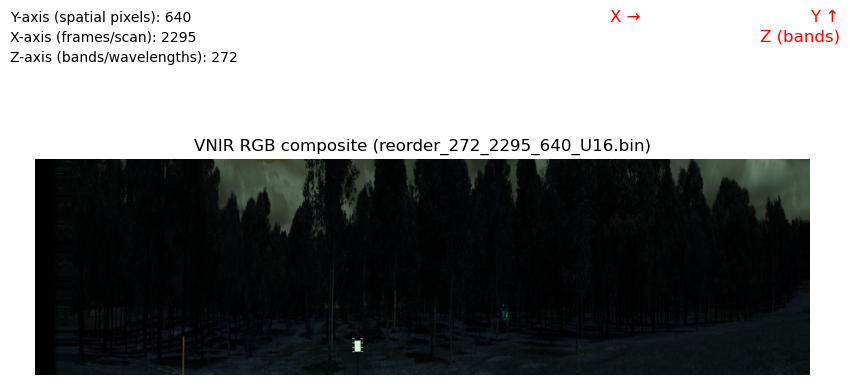

[detect_panel_region] (VNIR) cube shape (Y,X,B)=(640, 2295, 272)
[VNIR] detected bbox: (947, 540, 963, 569), height=29
VNIR panel height (pixels): 29
VNIR panel width (pixels): 16
VNIR panel bbox: (947, 540, 963, 569)
Saved panel overlay → reorder_272_2295_640_U16_vnir_panel_overlay.png


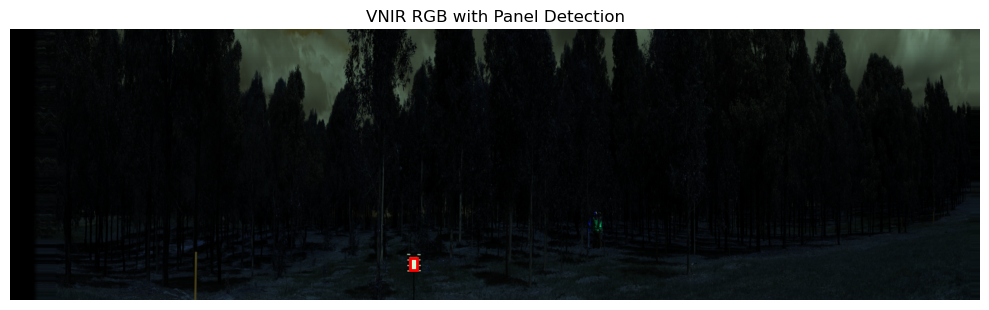

✅ VNIR panel detection visualization saved to: C:\Users\eric\Downloads\OneDrive_1_03-11-2025\20241002\Hyper\20241002103354_SCN\reorder_272_2295_640_U16_vnir_panel_overlay.png
Loaded cube: Reorder_288_2334_384_U16.bin  shape=(384, 2334, 288) (Y=384, X=2334, Bands=288)
Saved preview → Reorder_288_2334_384_U16_preview.png


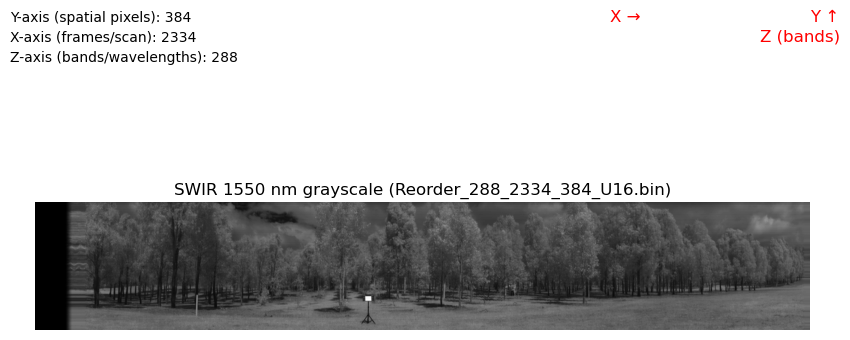

[overlay_scaled_vnir_on_swir] VNIR bbox (947, 540, 963, 569) → SWIR scaled bbox (994, 282, 1010, 294) (offset X=31.5, Y=-43.6, height_factor=0.65)
Saved overlay → Reorder_288_2334_384_U16_scaled_swir_panel_overlay.png


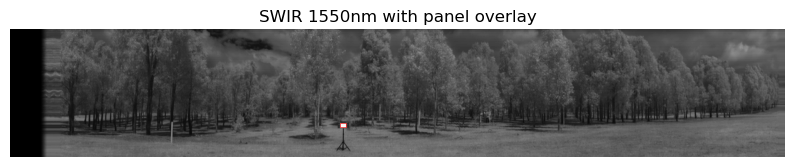

SWIR panel height (pixels): 12
SWIR panel width (pixels): 16
SWIR panel bbox (scaled + offset): (994, 282, 1010, 294)
✅ SWIR panel overlay visualization saved to: C:\Users\eric\Downloads\OneDrive_1_03-11-2025\20241002\SWIR\20241002103355\Reorder_288_2334_384_U16_scaled_swir_panel_overlay.png


In [3]:
## 3️⃣ Quick Test: Panel Detection and Visualization
import importlib
import panel_reflectance_pipeline as prp
importlib.reload(prp)

from panel_reflectance_pipeline import (
    import_datacube,
    detect_panel_region,
    overlay_scaled_vnir_on_swir,
    visualize_panel_detection
)

# === VNIR ===
vnir_file = ROOT_DIR / "20241002/Hyper/20241002103354_SCN/reorder_272_2295_640_U16.bin"
vnir_cube, vnir_wavelengths = import_datacube(vnir_file, verify_orientation=True)

# VNIR panel detection
panel_bbox_vnir, vnir_height = detect_panel_region(vnir_cube, vnir_file=vnir_file)
x1, y1, x2, y2 = panel_bbox_vnir
vnir_width = x2 - x1

print(f"VNIR panel height (pixels): {vnir_height}")
print(f"VNIR panel width (pixels): {vnir_width}")
print(f"VNIR panel bbox: {panel_bbox_vnir}")

# VNIR visualization
save_path_vnir = vnir_file.parent / f"{vnir_file.stem}_vnir_panel_overlay.png"
visualize_panel_detection(
    vnir_cube, vnir_wavelengths, panel_bbox_vnir,
    save_path=save_path_vnir,
    sensor_type="VNIR"
)
print(f"✅ VNIR panel detection visualization saved to: {save_path_vnir}")

# === SWIR ===
swir_file = ROOT_DIR / "20241002/SWIR/20241002103355/Reorder_288_2334_384_U16.bin"
swir_cube, swir_wavelengths = import_datacube(swir_file, verify_orientation=True)

# SWIR panel detection: scale VNIR box, apply offset & height reduction
save_path_swir_overlay = swir_file.parent / f"{swir_file.stem}_scaled_swir_panel_overlay.png"
panel_bbox_swir_scaled = overlay_scaled_vnir_on_swir(
    swir_cube,
    panel_bbox_vnir,
    vnir_file,
    swir_file,
    x_offset=31.5,       # manual X shift
    y_offset=-43.6,      # manual Y shift
    height_reduction_factor=0.65,
    save_path=save_path_swir_overlay
)

# Save scaled SWIR bbox dimensions
x1_s, y1_s, x2_s, y2_s = panel_bbox_swir_scaled
swir_width = x2_s - x1_s
swir_height = y2_s - y1_s

print(f"SWIR panel height (pixels): {swir_height}")
print(f"SWIR panel width (pixels): {swir_width}")
print(f"SWIR panel bbox (scaled + offset): {panel_bbox_swir_scaled}")
print(f"✅ SWIR panel overlay visualization saved to: {save_path_swir_overlay}")


In [4]:
## 4️⃣ Test / Check Panel Calibration File
from importlib import reload
import panel_reflectance_pipeline
reload(panel_reflectance_pipeline)

from panel_reflectance_pipeline import compute_panel_reflectance
import numpy as np

# Dummy cube for testing (y, x, bands)
cube = np.random.rand(10, 10, 100)
panel_bbox = (0, 0, 5, 5)
panel_file = "LARGE_PANEL.txt"
wavelengths = np.linspace(250, 2500, cube.shape[-1])

mean_signal, interp_ref = compute_panel_reflectance(cube, panel_bbox, panel_file, wavelengths=wavelengths)

print(mean_signal.shape, interp_ref.shape)

# should return (100,) (100,) if reflectance panel cube is correctly imported:

(100,) (100,)


In [5]:
## 5️⃣ Multi-Folder Processing with Verification
def process_day_folder(day_folder: Path):
    """
    Process VNIR and SWIR data within the given folder:
    - Detect panel regions
    - Extract panel reflectance → save as .nc
    - Extract regions around panel → normalize to panel → save as averaged reflectance .nc
    """
    print(f"\n--- Processing day folder: {day_folder.name} ---")

    # --- VNIR (Hyper) ---
    hyper_path = day_folder / VNIR_FOLDER
    if hyper_path.exists():
        scn_folders = [p for p in hyper_path.iterdir() if p.is_dir() and p.name.endswith("_SCN")]
        for scn_folder in scn_folders:
            bin_files = list(scn_folder.glob(VNIR_PATTERN))
            for bin_file in bin_files:
                print(f"  VNIR: {bin_file.name}")
                datacube, wavelengths = import_datacube(bin_file, verify_orientation=True)

                # 1️⃣ Detect VNIR panel
                panel_bbox, panel_height = detect_panel_region(datacube, vnir_file=bin_file)
                print(f"    Detected VNIR panel bbox: {panel_bbox}, height={panel_height}")

                # 2️⃣ Extract panel reflectance → save .nc
                panel_reflectance_cube, mean_signal, interp_ref = extract_panel_reflectance_cube(
                    datacube, panel_bbox, PANEL_CAL_FILE, wavelengths=wavelengths
                )
                panel_nc_path = scn_folder / "VNIR.panel.reflectance.nc"
                export_reflectance_to_netcdf(panel_reflectance_cube, wavelengths, panel_nc_path)

                # 3️⃣ Extract surrounding regions → normalized to panel reflectance
                region_reflectance = extract_region_around_panel(
                    datacube, panel_bbox, mean_signal, interp_ref, x_fraction=0.1
                )
                region_nc_path = scn_folder / "VNIR_averaged_vegetation_reflectance.nc"
                export_reflectance_to_netcdf(region_reflectance, wavelengths, region_nc_path)

                # Optional: export full corrected cube (like before)
                # corrected_cube = apply_reflectance_correction(datacube, mean_signal, interp_ref, panel_bbox)
                # export_reflectance_data(corrected_cube, scn_folder / f"{bin_file.stem}{REFL_SUFFIX}")

    # --- SWIR ---
    swir_path = day_folder / SWIR_FOLDER
    if swir_path.exists():
        scan_folders = [p for p in swir_path.iterdir() if p.is_dir()]
        for scan_folder in scan_folders:
            bin_files = list(scan_folder.glob(SWIR_PATTERN))
            for bin_file in bin_files:
                print(f"  SWIR: {bin_file.name}")
                datacube, wavelengths = import_datacube(bin_file, verify_orientation=True)

                # 1️⃣ Detect SWIR panel using scaled VNIR bbox if available
                # Look for previous VNIR file in same day folder
                try:
                    vnir_scn = day_folder / VNIR_FOLDER
                    vnirs = list(vnir_scn.rglob("reorder_*_U16.bin"))
                    if vnirs:
                        vnir_file = vnirs[0]
                        vnir_cube, _ = import_datacube(vnir_file)
                        panel_bbox_vnir, _ = detect_panel_region(vnir_cube, vnir_file=vnir_file)
                        panel_bbox_swir, _ = overlay_scaled_vnir_on_swir(
                            datacube, panel_bbox_vnir, vnir_file, bin_file,
                            x_offset=31.5, y_offset=-43.6, height_reduction_factor=0.65
                        )
                    else:
                        # Fallback: detect SWIR panel alone
                        panel_bbox_swir, _ = detect_panel_region(datacube, vnird_bbox=None, vnir_file=None, swir_file=bin_file)
                except Exception as e:
                    print("    SWIR panel detection failed:", e)
                    continue

                print(f"    SWIR panel bbox: {panel_bbox_swir}")

                # 2️⃣ Extract panel reflectance → save .nc
                panel_reflectance_cube, mean_signal, interp_ref = extract_panel_reflectance_cube(
                    datacube, panel_bbox_swir, PANEL_CAL_FILE, wavelengths=wavelengths
                )
                panel_nc_path = scan_folder / "SWIR.panel.reflectance.nc"
                export_reflectance_to_netcdf(panel_reflectance_cube, wavelengths, panel_nc_path)

                # 3️⃣ Extract surrounding regions → normalized to panel reflectance
                region_reflectance = extract_region_around_panel(
                    datacube, panel_bbox_swir, mean_signal, interp_ref, x_fraction=0.1
                )
                region_nc_path = scan_folder / "SWIR_averaged_vegetation_reflectance.nc"
                export_reflectance_to_netcdf(region_reflectance, wavelengths, region_nc_path)

                # Optional: export full corrected cube
                # corrected_cube = apply_reflectance_correction(datacube, mean_signal, interp_ref, panel_bbox_swir)
                # export_reflectance_data(corrected_cube, scan_folder / f"{bin_file.stem}{REFL_SUFFIX}")



In [6]:
## 6️⃣ Interactive Panel Polygon Editor
from matplotlib.widgets import PolygonSelector
from matplotlib.path import Path as MplPath

def edit_panel_region(datacube, initial_region=None):
    """Interactive region editor to redefine the panel region."""
    mean_image = datacube.mean(axis=2)
    fig, ax = plt.subplots()
    ax.imshow(mean_image, cmap="gray")
    ax.set_title("Drag vertices to adjust panel region.\nClose window to save polygon.")

    if initial_region is not None:
        poly = plt.Polygon(initial_region, fill=False, edgecolor='r', lw=2)
        ax.add_patch(poly)

    coords = []

    def onselect(verts):
        nonlocal coords
        coords = verts
        print("Polygon updated with vertices:", np.array(coords).round(2))

    selector = PolygonSelector(ax, onselect, useblit=True, lineprops=dict(color='r', lw=2))
    plt.show()
    return np.array(coords)

# Example use (after pipeline run):
# new_region = edit_panel_region(datacube, initial_region=panel_region)
# panel_refl = compute_panel_reflectance(datacube, new_region, PANEL_CAL_FILE)


[refine] chosen wavelengths: [1450.0, 1825.0, 2125.0]
[refine] band indices used: [86, 158, 215]
[refine] search box global coords x[922:1082] y[228:348]
[refine] brightest local (x,y) = (78,63) -> global (x,y)=(1000,291)
[refine] saved overlay image C:\Users\eric\Downloads\OneDrive_1_03-11-2025\20241002\SWIR\20241002103355\Reorder_288_2334_384_U16_refined_panel_overlay.png
[refine] saved bbox json C:\Users\eric\Downloads\OneDrive_1_03-11-2025\20241002\SWIR\20241002103355\Reorder_288_2334_384_U16_refined_panel_overlay.json
Refined bbox: (993, 284, 1007, 298)


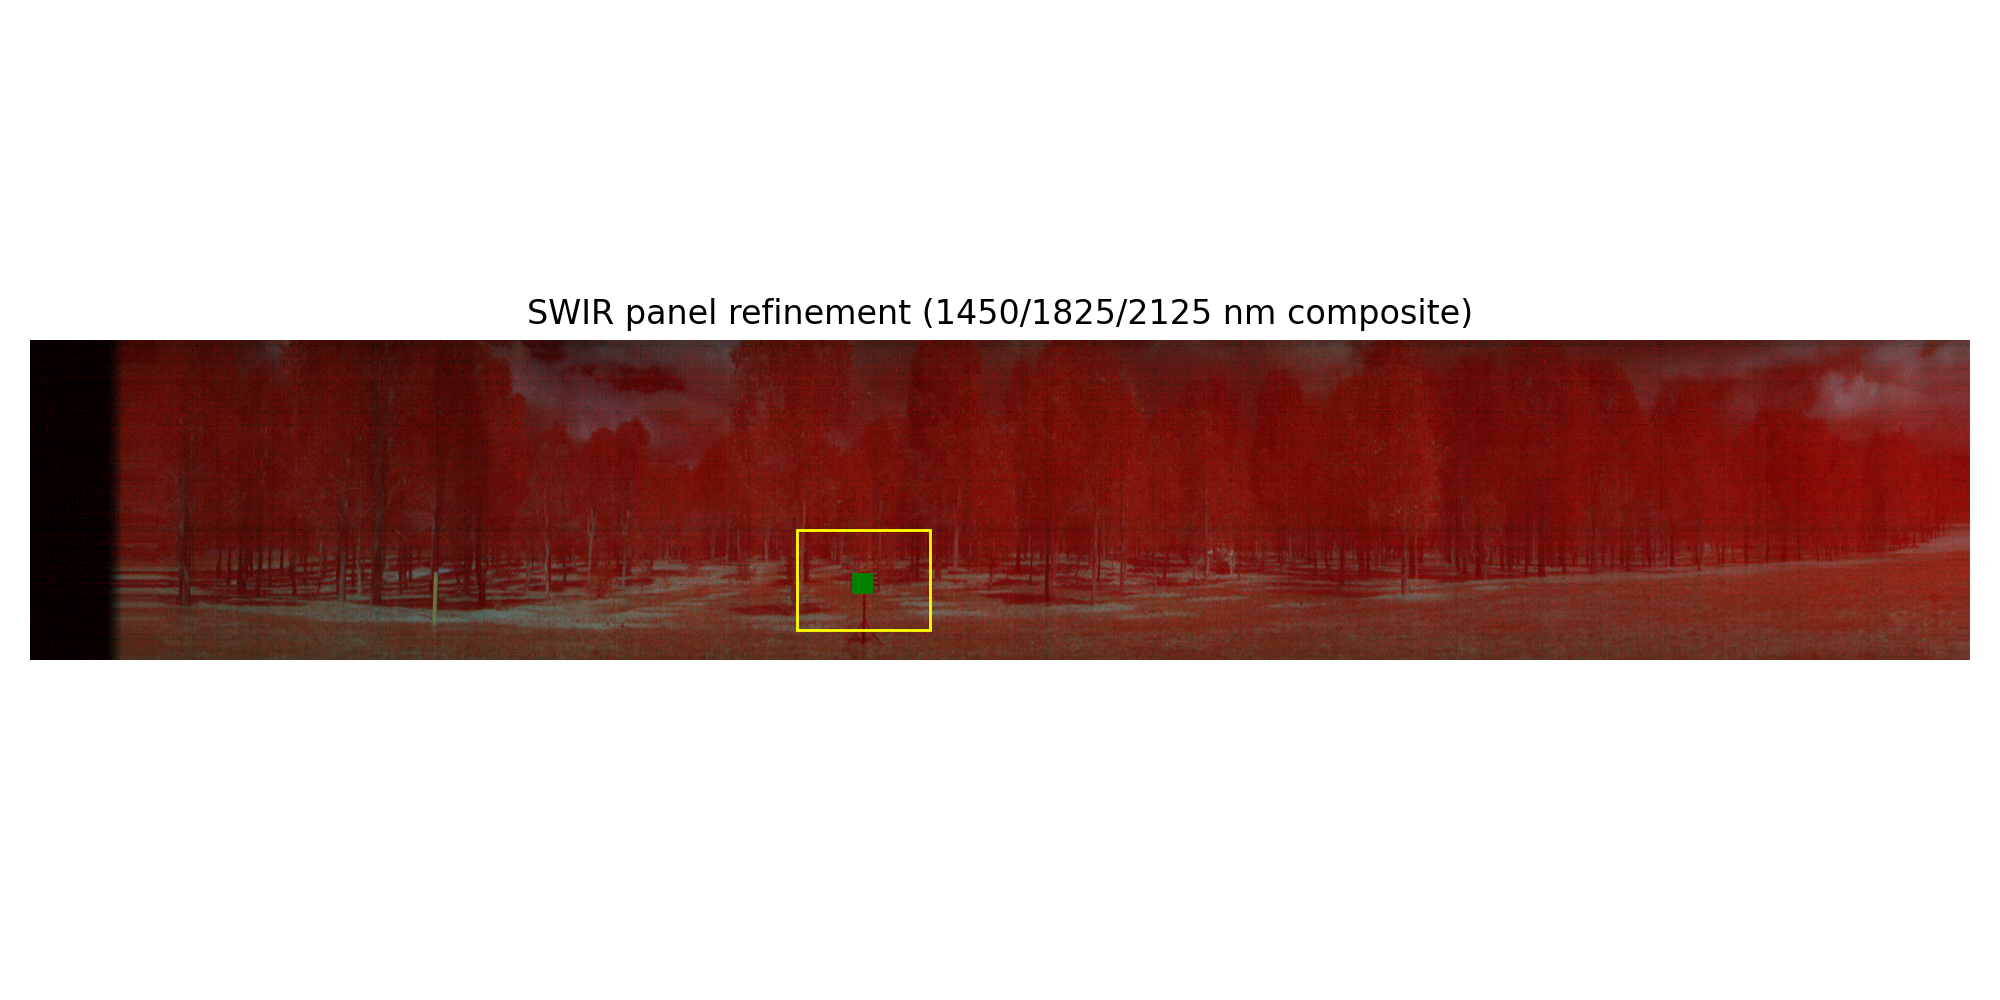

In [6]:
## 7️⃣ Refine SWIR Panel Detection
from panel_reflectance_pipeline import refine_swir_panel_bbox

save_path_refined = swir_file.parent / f"{swir_file.stem}_refined_panel_overlay.png"
refined_bbox, sub_crop = refine_swir_panel_bbox(
    cube_swir=swir_cube,
    prev_bbox=panel_bbox_swir_scaled,
    swir_file=swir_file,
    search_expand_factor=10,
    box_side_factor=1.0,
    save_path=save_path_refined,
    debug=True
)
print("Refined bbox:", refined_bbox)

# show saved image inline (if using notebook)
from IPython.display import Image, display
display(Image(str(save_path_refined)))


In [7]:
## 8️⃣ Extract Panel Reflectance and Save as NetCDF
from panel_reflectance_pipeline import (
    extract_panel_reflectance_cube,
    export_reflectance_to_netcdf,
    compute_panel_reflectance
)

# --- VNIR panel ---
vnir_panel_reflectance_cube, vnir_mean_signal, vnir_interp_ref = extract_panel_reflectance_cube(
    vnir_cube, panel_bbox_vnir, PANEL_CAL_FILE, wavelengths=vnir_wavelengths
)
vnir_panel_nc = vnir_file.parent / "VNIR.panel.reflectance.nc"
export_reflectance_to_netcdf(vnir_panel_reflectance_cube, vnir_wavelengths, vnir_panel_nc)

# Save the mean (scalar) panel reflectance (which should ~== vnir_interp_ref)
import pandas as pd
df_vnir_panel = pd.DataFrame({"wavelength": vnir_wavelengths, "panel_reflectance": np.nanmean(vnir_panel_reflectance_cube, axis=(0,1))})
df_vnir_panel.to_csv(vnir_file.parent / "VNIR.panel_avg_vals.csv", index=False)
print(f"Saved: {vnir_file.parent / 'VNIR.panel_avg_vals.csv'}")

# --- SWIR panel ---
swir_panel_reflectance_cube, swir_mean_signal, swir_interp_ref = extract_panel_reflectance_cube(
    swir_cube, panel_bbox_swir_scaled, PANEL_CAL_FILE, wavelengths=swir_wavelengths
)
swir_panel_nc = swir_file.parent / "SWIR.panel.reflectance.nc"
export_reflectance_to_netcdf(swir_panel_reflectance_cube, swir_wavelengths, swir_panel_nc)

df_swir_panel = pd.DataFrame({"wavelength": swir_wavelengths, "panel_reflectance": np.nanmean(swir_panel_reflectance_cube, axis=(0,1))})
df_swir_panel.to_csv(swir_file.parent / "SWIR.panel_avg_vals.csv", index=False)
print(f"Saved: {swir_file.parent / 'SWIR.panel_avg_vals.csv'}")


=== Panel conversion diagnostics ===
Panel pixel block shape: (29, 16, 272)
Mean panel reflectance (post-conversion) -> first 5 bands: [0.99159997 0.9916284  0.9918568  0.99186423 0.99195757]
Expected interp reflectance -> first 5 bands: [0.9916     0.99162841 0.99185683 0.99186421 0.99195756]
Max abs difference: 0.000000
Mean relative error: 0.000000
Saved NetCDF reflectance → VNIR.panel.reflectance.nc
Saved: C:\Users\eric\Downloads\OneDrive_1_03-11-2025\20241002\Hyper\20241002103354_SCN\VNIR.panel_avg_vals.csv
=== Panel conversion diagnostics ===
Panel pixel block shape: (12, 16, 288)
Mean panel reflectance (post-conversion) -> first 5 bands: [       nan 0.99130002 0.9913     0.99123206 0.99129059]
Expected interp reflectance -> first 5 bands: [0.9913     0.9913     0.9913     0.99123206 0.99129059]
Max abs difference: 0.000000
Mean relative error: 0.000000
Saved NetCDF reflectance → SWIR.panel.reflectance.nc
Saved: C:\Users\eric\Downloads\OneDrive_1_03-11-2025\20241002\SWIR\20241002

C:\Users\eric\Downloads\OneDrive_1_03-11-2025\panel_reflectance_pipeline.py:666: RuntimeWarning: Mean of empty slice
  panel_mean_after = np.nanmean(panel_reflectance, axis=(0, 1))
C:\Users\eric\AppData\Local\Temp\ipykernel_14804\2239001224.py:28: RuntimeWarning: Mean of empty slice
  df_swir_panel = pd.DataFrame({"wavelength": swir_wavelengths, "panel_reflectance": np.nanmean(swir_panel_reflectance_cube, axis=(0,1))})


In [8]:
## 9️⃣ Extract Vegetation Regions and Save
from panel_reflectance_pipeline import extract_region_around_panel, export_reflectance_to_netcdf

# Use the interpolated panel reflectance and mean raw signal to correct regions
vnir_veg_reflectance = extract_region_around_panel(
    vnir_cube, panel_bbox_vnir,
    interp_panel_reflectance=vnir_interp_ref, panel_mean_signal=vnir_mean_signal,
    x_fraction=0.1
)
# compute mean across y,x to produce average vegetation spectrum (bands,)
vnir_veg_mean = np.nanmean(vnir_veg_reflectance, axis=(0,1))
# Save small cube (we save the extracted region cube), but you requested an averaged product as .nc.
# We'll save both a small cube and the averaged CSV for convenience.
save_path_vnir_veg_nc = vnir_file.parent / "VNIR_vegetation_region.reflectance.nc"
export_reflectance_to_netcdf(vnir_veg_reflectance, vnir_wavelengths, save_path_vnir_veg_nc)

# Save averaged veg reflectance csv
import pandas as pd
pd.DataFrame({"wavelength": vnir_wavelengths, "reflectance": vnir_veg_mean}).to_csv(
    vnir_file.parent / "VNIR_averaged_vegetation_reflectance.csv", index=False
)
print(f"Saved VNIR vegetation reflectance cube and averaged CSV to {vnir_file.parent}")

# Repeat for SWIR
swir_veg_reflectance = extract_region_around_panel(
    swir_cube, panel_bbox_swir_scaled,
    interp_panel_reflectance=swir_interp_ref, panel_mean_signal=swir_mean_signal,
    x_fraction=0.1
)
swir_veg_mean = np.nanmean(swir_veg_reflectance, axis=(0,1))
save_path_swir_veg_nc = swir_file.parent / "SWIR_vegetation_region.reflectance.nc"
export_reflectance_to_netcdf(swir_veg_reflectance, swir_wavelengths, save_path_swir_veg_nc)
pd.DataFrame({"wavelength": swir_wavelengths, "reflectance": swir_veg_mean}).to_csv(
    swir_file.parent / "SWIR_averaged_vegetation_reflectance.csv", index=False
)
print(f"Saved SWIR vegetation reflectance cube and averaged CSV to {swir_file.parent}")


Saved NetCDF reflectance → VNIR_vegetation_region.reflectance.nc
Saved VNIR vegetation reflectance cube and averaged CSV to C:\Users\eric\Downloads\OneDrive_1_03-11-2025\20241002\Hyper\20241002103354_SCN
Saved NetCDF reflectance → SWIR_vegetation_region.reflectance.nc
Saved SWIR vegetation reflectance cube and averaged CSV to C:\Users\eric\Downloads\OneDrive_1_03-11-2025\20241002\SWIR\20241002103355


C:\Users\eric\AppData\Local\Temp\ipykernel_18344\3086375721.py:31: RuntimeWarning: Mean of empty slice
  swir_veg_mean = np.nanmean(swir_veg_reflectance, axis=(0,1))


In [8]:
## 1️⃣0️⃣ Review .nc Outputs, Export CSVs & Plot Verification
import xarray as xr
%matplotlib inline

def load_and_average_panel(nc_path: Path):
    """Load panel reflectance .nc and average across pixels."""
    ds = xr.open_dataset(nc_path)
    refl = ds["reflectance"].values
    wl = ds["wavelength"].values

    if refl.shape[0] != len(wl):
        refl = np.moveaxis(refl, -1, 0)

    if np.all(np.isnan(refl)):
        print(f"⚠️  Warning: all NaN values in {nc_path.name}, skipping.")
        return None

    mean_refl = np.nanmean(refl, axis=(1, 2))

    df = pd.DataFrame({"wavelength": wl, "reflectance": mean_refl})
    csv_path = nc_path.with_name(nc_path.stem.replace(".reflectance", "_avg_vals") + ".csv")
    df.to_csv(csv_path, index=False)
    print(f"✅ Saved: {csv_path.name}")
    return df


def load_and_plot_veg(nc_path: Path, label: str):
    """Load vegetation reflectance .nc and plot for visual QC."""
    ds = xr.open_dataset(nc_path)
    refl = ds["reflectance"].values
    wl = ds["wavelength"].values

    if refl.shape[0] != len(wl):
        refl = np.moveaxis(refl, -1, 0)

    if np.all(np.isnan(refl)):
        print(f"⚠️  Warning: all NaN values in {nc_path.name}, skipping plot.")
        return

    mean_refl = np.nanmean(refl, axis=(1, 2))

    plt.figure(figsize=(7, 4))
    plt.plot(wl, mean_refl, label=label, lw=1.5)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Reflectance")
    plt.title(f"Average Vegetation Reflectance – {label}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def review_netcdf_outputs(root_dir: Path):
    """Traverse all day folders, summarise VNIR/SWIR .nc outputs."""
    day_folders = [p for p in root_dir.iterdir() if p.is_dir() and p.name.isdigit()]

    for day in sorted(day_folders):
        print(f"\n📂 Day folder: {day.name}")

        # VNIR section
        vnir_path = day / "Hyper"
        if vnir_path.exists():
            scn_folders = [p for p in vnir_path.iterdir() if p.is_dir()]
            for scn in scn_folders:
                panel_nc = scn / "VNIR.panel.reflectance.nc"
                veg_nc = scn / "VNIR_averaged_vegetation_reflectance.nc"
                if panel_nc.exists():
                    df_vnir = load_and_average_panel(panel_nc)
                if veg_nc.exists():
                    load_and_plot_veg(veg_nc, f"VNIR Vegetation ({day.name})")

        # SWIR section
        swir_path = day / "SWIR"
        if swir_path.exists():
            scan_folders = [p for p in swir_path.iterdir() if p.is_dir()]
            for scan in scan_folders:
                panel_nc = scan / "SWIR.panel.reflectance.nc"
                veg_nc = scan / "SWIR_averaged_vegetation_reflectance.nc"
                if panel_nc.exists():
                    df_swir = load_and_average_panel(panel_nc)
                if veg_nc.exists():
                    load_and_plot_veg(veg_nc, f"SWIR Vegetation ({day.name})")

# === Run the review ===
review_netcdf_outputs(ROOT_DIR)



📂 Day folder: 20241002
✅ Saved: VNIR.panel_avg_vals.csv
✅ Saved: SWIR.panel_avg_vals.csv


C:\Users\eric\AppData\Local\Temp\ipykernel_14804\1977917678.py:18: RuntimeWarning: Mean of empty slice
  mean_refl = np.nanmean(refl, axis=(1, 2))
